In [1]:
using Iterators
using DataStructures
using Pipe
using Compat

macro printval(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr," = ", $ee)))
end

macro pz(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr,"\t\t",typeof($ee), "\t", size($ee))))
end

push!(LOAD_PATH, ".")
push!(LOAD_PATH, "../util")


4-element Array{ByteString,1}:
 "/home/ubuntu/build/julia-master/usr/local/share/julia/site/v0.5"
 "/home/ubuntu/build/julia-master/usr/share/julia/site/v0.5"      
 "."                                                              
 "../util"                                                        

In [2]:
using Packing
using Optim
push!(LOAD_PATH, "../Optimisation")
using AdaDelta

In [3]:
function clean(ss)
    @pipe (ss 
    |> replace(_, r"\[.*?\] ?","")  #Remove Nonword sounds
    |> replace(_, r"\<.*?\> ","")  #Remove Verbal Deltions
    |> replace(_, r"\*(.*?)\*",s"\1") #Remove mispronounciation marks
    |> replace(_,r"\:|\-\s\.\s\-", "") #remove intraword pauses
    |> replace(_,r"\w+\- ","") #remove stuttered words
    |> replace(_, r"[!\.,\?]","")        #Remove punctation as it is not used traditionally (see sro spec)
    
    |> replace(_, r"\s+",' ') #Remove repeated spaces
    #|> replace(_, r"([A-Z])\s([A-Z])", s"\1\2") #Merge len(2) abbrev
    |> replace(_, r".*[~\(\)\-\<\>#'].*","")#Remove everything if anything unfixable found
    |> lowercase
    |> strip 
    )
end


clean (generic function with 1 method)

In [4]:
const START_MARKER = "**START**"
const END_MARKER = "**END**"

"**END**"

In [18]:
path="../../Resources/corpora/atis2_text/"
function valid(ss)
    typeof(ss) <: ASCIIString  && length(ss)>0
end
    
corpus = @pipe readdir(path)  |> filter!(fn -> splitext(fn)[2]==".sro", _) |> map(_) do fn
    try open(readall, path*fn) end
    end |> filter!(valid,_) |> map(clean,_) |> filter!(valid,_) |> map(s->split(s),_);
corpus_vocab = @pipe corpus |> map(Set,_) |> reduce(union,_)
length(corpus_vocab)

1131

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:32
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/ubuntu/.julia/v0.5/IJulia/src/execute_request.jl:177
 in eventloop at /home/ubuntu/.julia/v0.5/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:443
while loading In[17], in expression starting on line 1
 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:32
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/ubuntu/.julia/v0.5/IJulia/src/execute_request.jl:177
 in eventloop at /home/ubuntu/.julia/v0.5/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:443
while loading In[17], in expression starting on line 1


In [19]:
using WordEmbeddings
LL, word_indexes, indexed_words = load_word2vec_embeddings("word_emb_data/GoogleNews-vectors-negative300.bin", length(corpus_vocab), corpus_vocab);

In [20]:
setdiff(corpus_vocab,indexed_words)


16-element Array{UTF8String,1}:
 "and"      
 "a"        
 "respeak"  
 "nondirect"
 "maluso"   
 "of"       
 "panam"    
 "stapleton"
 "fokker"   
 "lufthansa"
 "to"       
 "laguardia"
 "nonjets"  
 "hartfield"
 "mcdonnell"
 "dulles"   

In [21]:
#Kind of the opposite of a stop word. This word has little meaning (So zero value), but much structural importance
forcewords = ["and", "a", "of", "to"]
for word in forcewords
    @assert(!(word in indexed_words))
    push!(indexed_words, word)
    word_indexes[word] = length(indexed_words)
end
LL = [LL zeros(size(LL,1),length(forcewords))]

300x1119 Array{Float64,2}:
  0.0529562  -0.00851202  -0.0123606    …  -0.0548293   0.0  0.0  0.0  0.0
  0.0654598  -0.0342245   -0.0222299        0.0239878   0.0  0.0  0.0  0.0
  0.0661953   0.0322839    0.0655398       -0.0190492   0.0  0.0  0.0  0.0
  0.0470722   0.0458679    0.0394772        0.0826471   0.0  0.0  0.0  0.0
  0.0522207  -0.0131429   -0.0866199        0.0620861   0.0  0.0  0.0  0.0
 -0.0820086  -0.0462207    0.0249128    …   0.0465646   0.0  0.0  0.0  0.0
 -0.0614145  -0.00094823  -0.0111628       -0.0786156   0.0  0.0  0.0  0.0
 -0.11621    -0.0522188   -0.0705224       -0.0516041   0.0  0.0  0.0  0.0
  0.0156294   0.0465735    0.092369         0.00902063  0.0  0.0  0.0  0.0
  0.0992929   0.0624509    0.0927522        0.0364857   0.0  0.0  0.0  0.0
 -0.0856861  -0.122785    -0.0563412    …   0.0395094   0.0  0.0  0.0  0.0
 -0.028133   -0.0287556   -0.0605572       -0.0588609   0.0  0.0  0.0  0.0
  0.0522207   0.0515131   -0.0540416       -0.0903071   0.0  0.0  0.0  0.

In [22]:
@assert(!(START_MARKER in indexed_words))
push!(indexed_words, START_MARKER)
word_indexes[START_MARKER] = length(indexed_words)

@assert(!(END_MARKER in indexed_words))
push!(indexed_words, END_MARKER)
word_indexes[END_MARKER] = length(indexed_words)
LL = [LL zeros(size(LL,1),2)]

300x1121 Array{Float64,2}:
  0.0529562  -0.00851202  -0.0123606    …  0.0  0.0  0.0  0.0  0.0  0.0
  0.0654598  -0.0342245   -0.0222299       0.0  0.0  0.0  0.0  0.0  0.0
  0.0661953   0.0322839    0.0655398       0.0  0.0  0.0  0.0  0.0  0.0
  0.0470722   0.0458679    0.0394772       0.0  0.0  0.0  0.0  0.0  0.0
  0.0522207  -0.0131429   -0.0866199       0.0  0.0  0.0  0.0  0.0  0.0
 -0.0820086  -0.0462207    0.0249128    …  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0614145  -0.00094823  -0.0111628       0.0  0.0  0.0  0.0  0.0  0.0
 -0.11621    -0.0522188   -0.0705224       0.0  0.0  0.0  0.0  0.0  0.0
  0.0156294   0.0465735    0.092369        0.0  0.0  0.0  0.0  0.0  0.0
  0.0992929   0.0624509    0.0927522       0.0  0.0  0.0  0.0  0.0  0.0
 -0.0856861  -0.122785    -0.0563412    …  0.0  0.0  0.0  0.0  0.0  0.0
 -0.028133   -0.0287556   -0.0605572       0.0  0.0  0.0  0.0  0.0  0.0
  0.0522207   0.0515131   -0.0540416       0.0  0.0  0.0  0.0  0.0  0.0
  ⋮                                  

In [23]:
known_vocab = Set(indexed_words)
known_corpus = filter(corpus) do sent
    for word in sent
        if !( word in known_vocab)
            return false
        end
    end
    true
end;

In [24]:
################LOADING Done, Now processing

In [25]:
using DataStructures

function Base.sum(acc::Accumulator)
    sum(values(acc.map))
end

function Base.sum(acc::Dict)
    sum(values(acc))
end

function freq2prob{T,V<:Number}(acc::Union{Accumulator{T,V},Dict{T,V}})
    
    ret=Dict{T,Float64}()
    total = sum(acc)
    for (k,v) in acc
        ret[k]=v/total
    end
    ret
end

function dict2mat(bigrams::Dict, word_indexes::Dict{AbstractString,Int64}, dense=False)
    mat  = (dense ? zeros: spzeros)(length(word_indexes),length(word_indexes))
    for first in keys(bigrams)
        for second in keys(bigrams[first])
            mat[word_indexes[second], word_indexes[first]] = bigrams[first][second]
        end
    end
    mat
end


dict2mat (generic function with 2 methods)

In [26]:
function collect_cooccur_stats(sentences)
    unioccur = counter(AbstractString)
    bioccur = DefaultDict(()->counter(AbstractString))
    
    for sent in sentences
        for ii in 1:length(sent)
            push!(unioccur, sent[ii])
            for jj in 1:length(sent)
                if ii==jj
                    continue
                end
                push!(bioccur[sent[ii]], sent[jj])    
            end
        end       
    end
    
    [k=>v.map for (k,v) in bioccur], unioccur.map
    
end

bioccur_freq, unioccur_freq = collect_cooccur_stats(known_corpus)

bioccur_mat = dict2mat(bioccur_freq,word_indexes,true)
bioccur_mat.+=1.0 # Add one smoothing
bioccur_mat./=sum(bioccur_mat)

unioccur = freq2prob(unioccur_freq)
unioccur_vec = Float64[haskey(unioccur,word) ? unioccur[word] : 0.0 for word in indexed_words]

unioccur_vec_smoothed = Float64[word in keys(unioccur_freq) ? unioccur_freq[word] : 0.0 for word in indexed_words]
unioccur_vec_smoothed.+=1.0 # Add one smoothing
unioccur_vec_smoothed./=sum(unioccur_vec_smoothed)

1121-element Array{Float64,1}:
 0.0122194  
 0.00815654 
 0.00759482 
 0.0190217  
 0.0264472  
 0.00253161 
 3.07794e-5 
 0.000100033
 0.0413137  
 0.00324723 
 0.000230846
 0.000430912
 0.00122348 
 ⋮          
 3.84743e-5 
 6.15588e-5 
 5.3864e-5  
 0.000169287
 1.53897e-5 
 0.0138507  
 0.0112268  
 0.0190755  
 0.0119963  
 0.0501397  
 7.69485e-6 
 7.69485e-6 

In [27]:
using Gadfly
using Distributions

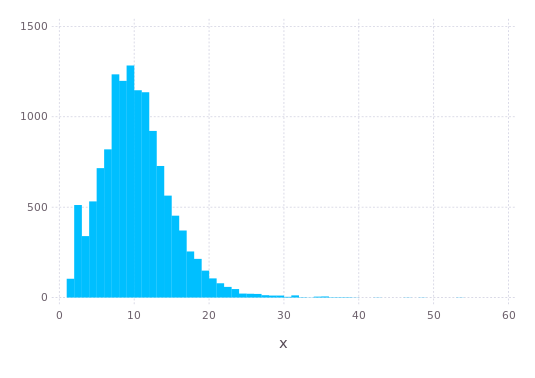

In [28]:
sent_lengths = map(length, known_corpus)
plot(x=sent_lengths, Geom.histogram)

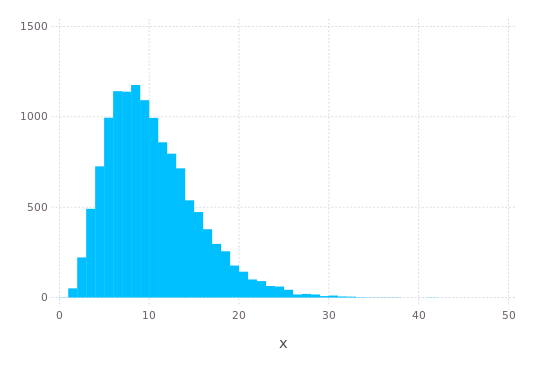

In [29]:
sent_length_dist = fit_mle(Gamma, sent_lengths)
plot(x=[round(rand(sent_length_dist)) for _ in 1:length(sent_lengths)], Geom.histogram)

In [30]:
length_prob=cdf(sent_length_dist,[1.5:1.0:50.5])-cdf(sent_length_dist,[0.5:1.0:49.5])


50-element Array{Float64,1}:
 0.00396232
 0.017689  
 0.0378689 
 0.0583838 
 0.0748904 
 0.0854289 
 0.0898418 
 0.0890139 
 0.0842629 
 0.076946  
 0.0682473 
 0.0590932 
 0.0501436 
 ⋮         
 4.06294e-5
 2.94188e-5
 2.12629e-5
 1.53417e-5
 1.10512e-5
 7.94813e-6
 5.70783e-6
 4.09313e-6
 2.9312e-6 
 2.09636e-6
 1.49741e-6
 1.06829e-6

In [108]:
using UnicodePlots

nw = zip(unioccur_vec,indexed_words) |> collect
freq,name = zip(select!(nw, 1:20, by=fw->-fw[1])...) |> collect

barplot(name|> collect,freq|> collect)
IJulia.display(barplot(name|> collect,(freq|> collect)))
sleep(3)
IJulia.display(barplot(name|> collect,2*(freq|> collect)))

             ┌────────────────────────────────────────┐ 
          to │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.0505681641777143 │ 
         the │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.041665373032382255   │ 
        from │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.04026824800521593    │ 
     flights │▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.032149399236238316      │ 
      flight │▪▪▪▪▪▪▪▪▪▪▪ 0.02899034431370114         │ 
          on │▪▪▪▪▪▪▪▪▪▪▪ 0.026669564407463753        │ 
        what │▪▪▪▪▪▪▪▪▪▪ 0.02633580676208513          │ 
           a │▪▪▪▪▪▪▪▪ 0.019233754540656338           │ 
          is │▪▪▪▪▪▪▪▪ 0.01917942190071098            │ 
      boston │▪▪▪▪▪▪▪ 0.017914247570554813            │ 
          me │▪▪▪▪▪▪▪ 0.01698283088577727             │ 
           i │▪▪▪▪▪▪ 0.014631003756713962             │ 
        show │▪▪▪▪▪▪ 0.014320531528454779             │ 
         san │▪▪▪▪▪▪ 0.013986773883076158             │ 
   francisco │▪▪▪▪▪▪ 0.01396348846595672              │ 
      denver │▪▪▪▪▪ 0.013746157906175293              │ 
          in │▪▪▪▪▪ 0.012317985

             ┌────────────────────────────────────────┐ 
          to │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.1011363283554286 │ 
         the │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.08333074606476451    │ 
        from │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.08053649601043186    │ 
     flights │▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.06429879847247663       │ 
      flight │▪▪▪▪▪▪▪▪▪▪▪ 0.05798068862740228         │ 
          on │▪▪▪▪▪▪▪▪▪▪▪ 0.05333912881492751         │ 
        what │▪▪▪▪▪▪▪▪▪▪ 0.05267161352417026          │ 
           a │▪▪▪▪▪▪▪▪ 0.038467509081312676           │ 
          is │▪▪▪▪▪▪▪▪ 0.03835884380142196            │ 
      boston │▪▪▪▪▪▪▪ 0.035828495141109626            │ 
          me │▪▪▪▪▪▪▪ 0.03396566177155454             │ 
           i │▪▪▪▪▪▪ 0.029262007513427925             │ 
        show │▪▪▪▪▪▪ 0.028641063056909558             │ 
         san │▪▪▪▪▪▪ 0.027973547766152317             │ 
   francisco │▪▪▪▪▪▪ 0.02792697693191344              │ 
      denver │▪▪▪▪▪ 0.027492315812350586              │ 
          in │▪▪▪▪▪ 0.024635971

In [84]:
function collect_grams_stats(sentences)
    unigrams = counter(AbstractString)
    bigrams = DefaultDict(()->counter(AbstractString))
    
    for sent in sentences
        push!(bigrams[START_MARKER], sent[1])
        for ii in 1:length(sent)-1
            push!(unigrams,sent[ii])
            push!(bigrams[sent[ii]], sent[ii+1])    
        end
        push!(unigrams,sent[end])
        push!(bigrams[sent[end]], END_MARKER)
    end
    
    
    [k=>v.map for (k,v) in bigrams], unigrams.map
end




collect_grams_stats (generic function with 1 method)

In [32]:
using StatsBase
# modified from https://github.com/JoFrhwld/GoodTuring.jl/blob/master/GoodTuring.jl
function simpleGoodTuring(speciesCountDict::Dict)
    speciesCountVec = collect(values(speciesCountDict))
        
    totalCounts = sum(speciesCountVec)
    cofcDict = countmap(speciesCountVec)
    r = sort(collect(keys(cofcDict)))

    N = size(r,1)
    Nr = [cofcDict[r[i]] for i in 1:N]

    p0 = haskey(cofcDict, 1.0) ? cofcDict[1.0] / totalCounts : 0.0
    
    Z = sgtZ(r,Nr)
    logr = map(log,r)
    logZ = map(log,Z)

    X = hcat(ones(N), logr)
    Y = copy(logZ )
    coefs = X\Y
    intercept = coefs[1]
    slope = coefs[2]

    useY = false
    rSmooth = Array{Float64}(N)
    for i in 1:N
        @inbounds thisr = r[i]
        
        #y = ((thisr+1.0)^(slope+1.0))/(thisr^slope)
        #The above is the much simplified form of the below (Performance identical output differs by 10^-16)
        y = (thisr+1.0) * exp(slope * log(thisr+1.0) + intercept) / exp(slope * log(thisr) + intercept)

        if !in(thisr+1, r)
            useY = true
        end

        if useY
            rSmooth[i] = y
        else
            x = (thisr+1) * cofcDict[thisr + 1]/cofcDict[thisr]
            thisNr = cofcDict[thisr]
            thisNr1 = cofcDict[thisr+1]

            t = 1.96 * ((thisr+1)^2) * (thisNr1 / thisNr^2) * (1 + (thisNr1 / thisNr))

            if abs(x-y) > t
                @inbounds rSmooth[i] = x
            else
                useY = true
                @inbounds rSmooth[i] = y
            end
        end
    end

    smoothTot = sum(Nr.*rSmooth)
    sgtProb  = (1.0 - p0) .* (rSmooth/smoothTot)
    sgtProbDict = Dict([r[i] => sgtProb[i] for i in 1:N])
    sgtDict = Dict([sp=>sgtProbDict[speciesCountDict[sp]] for sp in keys(speciesCountDict)])

    sgtDict, sgtProbDict, p0
end


function sgtZ(r::Array, Nr::Array)
    j = r
    i = [0; j[1:end-1]]
    lastK = 2*j[end] - i[end]
    k = [j[2:end]; lastK]
    Float64[(2*Nr[iter])/(k[iter]-i[iter]) for iter = 1:length(j)]
end

function simpleGoodTuring(speciesCountVec::Vector)
    sgtD = simpleGoodTuring(Dict([ii=>v for (ii,vv) in enumerate(speciesCountVec)]))
    [sgtD[ii] for ii in 1:length(speciesCountVec)]
end

simpleGoodTuring (generic function with 2 methods)

In [33]:

function katz_bigrams(bigram_freq::Dict, unigrams_freq::Dict)
    k_bigrams = Dict()
    
    for first in keys(bigram_freq)
        smoothed,_,p0 = simpleGoodTuring(bigram_freq[first])
        k_bigrams[first] = smoothed
        
        backoff_keys = setdiff(keys(unigram_freq),keys(smoothed))
        #share the p0 proability mass between them
        total = sum([unigrams_freq[key] for key in backoff_keys])
        for second in backoff_keys
            k_bigrams[first][second]=p0.*unigrams_freq[second]./total
        end
    end
    k_bigrams
end

bigram_freq, unigram_freq = collect_grams_stats(known_corpus);
kbigrams=katz_bigrams(bigram_freq, unigram_freq)
kbigrams_mat = dict2mat(kbigrams,word_indexes,true)

1121x1121 Array{Float64,2}:
 0.000738563  0.000845547  0.00104524   …  0.000216622  0.00248123   0.0
 0.000738563  0.00254699   0.000843736     0.000144551  0.000804161  0.0
 0.00293742   0.0166282    0.000649407     0.000106928  0.000424392  0.0
 0.000462381  0.00131654   0.0175479       0.000337286  0.0342978    0.0
 0.000642955  0.00183069   0.00166171      0.000469007  0.00728763   0.0
 6.13763e-5   0.000174757  0.00021603   …  4.47713e-5   0.000198714  0.0
 5.61369e-7   1.59839e-6   1.97588e-6      4.09494e-7   8.01806e-7   0.0
 2.24548e-6   6.39355e-6   0.00166171      1.63798e-6   3.20723e-6   0.0
 0.243514     0.0948053    0.00459815      0.00608653   0.00522763   0.0
 0.00108937   0.000565209  0.000843736     5.74656e-5   0.000500169  0.0
 5.42657e-6   1.54511e-5   1.91002e-5   …  3.95844e-6   0.000125023  0.0
 1.02918e-5   2.93038e-5   3.62245e-5      7.50739e-6   1.46998e-5   0.0
 2.95654e-5   8.41817e-5   0.000104063     2.15667e-5   0.000273493  0.0
 ⋮                     

In [34]:
open("atis_data.jsz","w") do fh
    data = Dict([
        ("bigrams", kbigrams_mat),
        ("bioccur", bioccur_mat),
        ("unioccur", unioccur_vec),
        
        ("length_prob", length_prob),
        ("LL",LL),
        ("word_indexes", word_indexes),
        ("indexed_words", indexed_words),
        ])
    serialize(fh, data)    
end

In [48]:
function likelyhood(sent, bigrams)
    words = split(sent)
    words = [START_MARKER; words; END_MARKER]
    
    p=1.0
    for ii in 1:length(words)-1
        p*=bigrams[words[ii]][words[ii+1]]
    end
    p
end


function select_word{S<:AbstractString,V}(unigrams::Dict{S,V})
    cutoff = rand()
    total = 0.0
    for next_word in keys(unigrams)
        total+=unigrams[next_word]
        if total>=cutoff
            return next_word
        end
    end
    assert(False, "Should never reach here") 
end

function random_walk(bigrams)
    words=[]
    cur = START_MARKER
    while(cur!=END_MARKER)
        cur = select_word(bigrams[cur])
        push!(words,cur)
    end
    words = words[1:end-1]
    join(words, " ")
end

walk =random_walk(kbigrams) 
print(walk*"\t")
print(likelyhood(walk,kbigrams))

show me about what is the earliest flight from philadelphia	9.818120434988046e-10

In [ ]:
LL

Frame's Extra Magic Mass-Sharing Co-occurance PMF, Inspired by Bengio 2003
---

In [ ]:
addprocs(11)

In [ ]:
@everywhere immutable LU_NN{N<:Number}
    C::Matrix{N} #lookup matrix
    H::Matrix{N}
    d::Vector{N}
    U::Matrix{N}
    b::Vector{N}
end

In [ ]:
subset_indexes_for_len = Dict{Int,Vector{Vector{Bool}}}()


function prepare_cases(sentence)
    xs = Int[word_indexes[word] for word in sentence]
    K = length(xs)
    ss ::Vector{Vector{Bool}} = if haskey(subset_indexes_for_len,K)
            subset_indexes_for_len[K]
        else 
            subset_indexes_for_len[K] = Vector{Bool}[collect(pr) for pr in  product([(true,false) for k in 1:K]...)][2:end-1]
        end
    
    CT = Tuple{Vector{Int},Vector{Int}}
    #vcat([CT[(xs[bb],[y]) for y in xs[!bb]] for bb in ss]...)
    CT[(xs[bb],xs[!bb]) for bb in ss]
    
end

In [ ]:
training_cases = @pipe known_corpus |> map(prepare_cases,_) |> vcat(_...)

In [ ]:
function LU_NN(dEmb, dHidden, dOut)
    LU_NN(
        0.01*(randn((dEmb,dOut))), #C
        0.01*(randn((dHidden,dEmb))), #H
        0.01*(randn(dHidden)), #d
        0.01*(randn((dOut,dHidden))), #U
        0.01*(randn(dOut))#b
    )
end

In [ ]:
@everywhere function softmax(xs)
    numer = exp(xs)
    numer./sum(numer)
end


@everywhere function σ(xs)
    1.0./(1+exp(-xs))
end

#########################################



@everywhere function δ(δ_above, W)
    (W'*δ_above)
end

@everywhere function δ_tanh(δ_above, a)
    const dz = 1-a.^2
    δ_above.*dz
end

@everywhere function δ_σ(δ_above, a)
    const dz = a .- a.^2
    δ_above.*dz
end

@everywhere function δ_softmax_ce(actual, expected)
    actual-expected
end

@everywhere function δ_output_sq_loss(actual, expected) 
    -(expected-actual)
end

#############################################

@everywhere function sq_loss(actual, expected)
    0.5*sum((expected-actual).^2)
end

@everywhere function ce_loss(actual, expected)
    @assert(all(actual.>0))
    -sum(expected.*log(actual))
end

@everywhere function forward(x,nn::LU_NN)
    aa = tanh(nn.H*x+nn.d)
    out = softmax(nn.U*aa + nn.b)
    out, aa
end

@everywhere function feedforward_backprop(xx,nn::LU_NN, expected_output)
    actual_output, aa = forward(xx,nn)
    err = ce_loss(actual_output, expected_output)
    #δ_top = δ_tanh(δ_softmax_ce(actual_output, expected_output),actual_output)
    δ_top = δ_softmax_ce(actual_output, expected_output)
    ΔU  = δ_top*aa'
    Δb  = δ_top
    δ_hidden = δ_tanh(δ(δ_top, nn.U),aa)
    ΔH  = δ_hidden*xx'
    Δd  = δ_hidden
    δ_bottom = δ(δ_hidden, nn.H)
    Δx  = δ_bottom
    Δx,ΔH,Δd,ΔU,Δb,err

end

In [ ]:
@everywhere function mysubarray(xs, id=myid(), nchunks=nworkers())
    #THis is broken if workers are not sequentially numbered from 2:nworkers
    len = length(xs)
    chunk_size = div(len, nchunks+1)
    start_index = (id-2)*chunk_size + 1
    end_index = start_index+chunk_size-1
    print(start_index : end_index)
    sub(xs, start_index : end_index)
end

@everywhere function expand_training_case(given_iis, target_iis, nn)
    given_sowe = length(given_iis)>0 ? sum([nn.C[:,g_ii] for g_ii in given_iis]) : zeros(nn.C[:,1])
    target = zeros(nn.b) #just while we are testing use a one hot set rep
    for t_ii in target_iis
        target+=1.0/length(target_iis)
    end
    given_sowe,target
end

@everywhere function train_one(given_iis, target_iis, nn)
    given_sowe,target = expand_training_case(given_iis, target_iis, nn)
        
    Δx,ΔH,Δd,ΔU,Δb,err = feedforward_backprop(given_sowe,nn, target)
    
    ΔC = zeros(nn.C)
    for g_ii in given_iis
        @inbounds ΔC[:, g_ii]+=Δx./length(given_iis)
    end
    ΔC,ΔH,Δd,ΔU,Δb,err
end


function train_all(training_cases,nn)
    
    function accumulate_training_over(cases,fun)
        totals = Any[  
            zeros(nn.C),
            zeros(nn.H),
            zeros(nn.d),
            zeros(nn.U),
            zeros(nn.b),
            0.0]
        for case in cases
            Δs = fun(case)
            for ii in 1:length(totals)
                totals[ii]+=Δs[ii]
            end
        end
        totals
    end
    
    function train_remote()
        accumulate_training_over(mysubarray(training_cases),
                                 gt_iis -> train_one(gt_iis[1], gt_iis[2], nn) )
    end
    
    r_updates = [@spawnat(id, train_remote())  for id in workers()]
        
    totals = accumulate_training_over(r_updates, fetch)
    ([tot./length(training_cases) for tot in totals]...)
end
    

In [ ]:
function uncached_loss_and_loss_grad!(θ::Vector, grad::Vector)    
    unpack!(θ, nn_outer)
    train_results = train_all(training_cases, nn_outer)
    Δs = train_results[1:end-1]
    err = train_results[end]
    pack!(grad, Δs...)
    err+0.01*sum(θ.^2)
end

_loss_and_loss_grad=Dict{Vector{Float64},Tuple{Float64, Vector{Float64}}}()
function loss_and_loss_grad!(θ::Vector, grad::Vector)    
    if haskey(_loss_and_loss_grad,θ)
        err, grad[:]= _loss_and_loss_grad[θ]
    else
        err = uncached_loss_and_loss_grad!(θ, grad)
        _loss_and_loss_grad[θ] = (err, copy(grad))
    end
    err
end

function loss!(θ::Vector)  
    global nn_outer
    unpack!(θ, nn_outer)
    total_loss = @parallel (+) for (g_ii, t_ii) in training_cases
        x, target = expand_training_case(g_ii, t_ii,nn_outer)
        actual, _ = forward(x,nn_outer)
        ce_loss(actual, target)    
    end
    total_loss/length(training_cases)

end

function loss_grad!(θ::Vector, grad::Vector) 
    #warn("loss_grad not defined")
    loss_and_loss_grad!(θ, grad)
end


In [ ]:
using MultivariateStats

In [ ]:
dEmb = 9
nn_outer = LU_NN(dEmb, 6, length(indexed_words));
nn_outer.b[:] = unioccur_vec;

nn_outer.C[:] = transform(fit(PCA, LL; maxoutdim=dEmb), LL) |> vec


θ=pack(nn_outer)

In [ ]:
loss!(θ)

In [ ]:
opt_func = DifferentiableFunction(loss!,loss_grad!,loss_and_loss_grad!)

@time res = optimize(opt_func, θ, method=:l_bfgs, show_trace = true, store_trace = true, iterations = 10);
#@time res = adadelta(opt_func, θ, show_trace = true, iterations = 500);
@printval res.f_calls 
@printval res.g_calls 
@printval res.iterations
@printval res.f_minimum
@printval res.gr_converged
@printval res.x_converged                       
@printval res.f_converged 


In [ ]:
sowe = nn_outer.C[:,word_indexes["find"]]
ns,_ = forward(sowe,nn_outer)
indexed_words[findmax(ns)[2]]

In [ ]:
@printval res.gr_converged
@printval res.x_converged                       
@printval res.f_converged 


In [ ]:
ns

In [ ]:
var(bb)

In [ ]:
var(WW)

In [ ]:
nn_outer = LU_NN(8, 16, 19);

xx=sum([nn_outer.C[:,g_ii] for g_ii in [1,2,3]])
target = zeros(nn_outer.b)
target[[10,11,12]]=1.0/3


using ForwardDiff

function f(θ)
    x,H,d,U,b = unpack(θ,size(xx),(16,8),16,(19,16),19) 
    nn =  LU_NN(0.0*H, H,d,U,b)#using 0.0*H as a dummy value for C
    
    actual, _=forward(x,nn)
    sq_loss(actual, target)
end

function calc_ag(θ)
    x,H,d,U,b = unpack(θ,size(xx),(16,8),16,(19,16),19)
    nn =  LU_NN(0.0*H, H,d,U,b) #using 0.0*H as a dummy value for C
    Δx,ΔH,Δd,ΔU,Δb,err = feedforward_backprop(x,nn, target)
end

g = ForwardDiff.gradient(f)

t=pack(xx,nn_outer.H,nn_outer.d,nn_outer.U,nn_outer.b)
a_x, a_H, a_d, a_U, a_b, a_err = calc_ag(t)
dg = g(t)  #Commented out so can't be run  
d_x, d_H, d_d, d_U, d_b = unpack(dg,size(xx),(16,8),16,(19,16),19)


@printval f(t) == a_err
@printval findmax(abs(d_x .- a_x))
@printval findmax(abs(d_H .- a_H))
@printval findmax(abs(d_d .- a_d))
@printval findmax(abs(d_U .- a_U))
@printval findmax(abs(d_b .- a_b))

In [ ]:
[a_err f(t)]

In [ ]:
f(t)

In [ ]:
a_err